
# Week 6 — WPBC Logistic Regression Assignment

**Dataset:** Wisconsin Prognostic Breast Cancer (WPBC)  
**Goal:** Prepare data, build logistic regression models, compare as classifiers, and evaluate against baselines (null and permutation).




In [1]:

# === Imports & Utility Setup ===
import os, math, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, KFold
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    confusion_matrix, accuracy_score, precision_score, recall_score,
    roc_curve, auc, precision_recall_curve, average_precision_score,
    brier_score_loss, log_loss
)

import statsmodels.api as sm
import statsmodels.formula.api as smf

sns.set_context("notebook")
warnings.filterwarnings("ignore", category=FutureWarning)
np.set_printoptions(suppress=True, linewidth=160)
pd.set_option("display.width", 160)
pd.set_option("display.max_columns", 100)



## Problem 1 — Preparing the data

- Load `wpbc.data` (198 rows expected).  
- Check for missing values and **impute** (mean/median/mode) and **justify**.  
- Create `recur24 = 1` if `outcome == 'R'` and `time < 24`, else `0`.  
- Plot each predictor vs response.


In [2]:

# === P1.1 Load data ===
# Set this to your local path for wpbc.data
DATA_PATH = '/Users/codylewis/Desktop/AIHC 5615/Week 6/wpbc.data'  

colnames = ["id", "outcome", "time", "radius", "texture", "perimeter", "area",
"smoothness", "compactness", "concavity", "concave_points", "symmetry",
"fractal_dimension", "radius_se", "texture_se", "perimeter_se", "area_se",
"smoothness_se", "compactness_se", "concavity_se", "concave_points_se",
"symmetry_se", "fractal_dimension_se", "radius_worst", "texture_worst",
"perimeter_worst", "area_worst", "smoothness_worst", "compactness_worst",
"concavity_worst", "concave_points_worst", "symmetry_worst",
"fractal_dimension_worst", "tumor_size", "lymph_stats"]

# wpbc.data typically uses '?' for missing
df = pd.read_csv(DATA_PATH, header=None, names=colnames, na_values=["?","NA","NaN","nan",""])
print(df.shape)
df.head()


(198, 35)


,id,outcome,time,radius,texture,perimeter,area,smoothness,compactness,concavity,concave_points,symmetry,fractal_dimension,radius_se,texture_se,perimeter_se,area_se,smoothness_se,compactness_se,concavity_se,concave_points_se,symmetry_se,fractal_dimension_se,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst,tumor_size,lymph_stats
0,119513,N,31,18.02,27.60,117.50,1013.0,0.09489,0.1036,0.1086,0.07055,0.1865,0.06333,0.6249,1.8900,3.972,71.55,0.004433,0.01421,0.03233,0.009854,0.01694,0.003495,21.63,37.08,139.70,1436.0,0.1195,0.1926,0.3140,0.1170,0.2677,0.08113,5.0,5.0
1,8423,N,61,17.99,10.38,122.80,1001.0,0.11840,0.2776,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.015870,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,3.0,2.0
2,842517,N,116,21.37,17.44,137.50,1373.0,0.08836,0.1189,0.1255,0.08180,0.2333,0.06010,0.5854,0.6105,3.928,82.15,0.006167,0.03449,0.03300,0.018050,0.03094,0.005039,24.90,20.98,159.10,1949.0,0.1188,0.3449,0.3414,0.2032,0.4334,0.09067,2.5,0.0
3,843483,N,123,11.42,20.38,77.58,386.1,0.14250,0.2839,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.018670,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,2.0,0.0
4,843584,R,27,20.29,14.34,135.10,1297.0,0.10030,0.1328,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.018850,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,3.5,0.0


In [3]:

# === P1.2 Check missing ===
n_missing = df.isna().sum().sort_values(ascending=False)
print("Missing by column:\n", n_missing)

assert df.shape[0] == 198, f"Expected 198 observations, got {df.shape[0]}"


Missing by column:
 lymph_stats                4
outcome                    0
id                         0
time                       0
radius                     0
perimeter                  0
texture                    0
smoothness                 0
compactness                0
concavity                  0
area                       0
symmetry                   0
fractal_dimension          0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
concave_points             0
compactness_se             0
concavity_se               0
symmetry_se                0
concave_points_se          0
radius_worst               0
texture_worst              0
perimeter_worst            0
fractal_dimension_se       0
area_worst                 0
smoothness_worst           0
concavity_worst            0
compactness_worst          0
concave_points_worst       0
symmetry_worst             0
fractal_dimension_worst


**Imputation choice:**  I imputed numerical columns with the **median** (robust to skew/outliers common in biomedical measures) and **categorical** with the **mode**. WPBC features are continuous and right-skewed, so median preserves central tendency without distortion.


In [4]:

# === P1.2 Impute ===
numeric_cols = df.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = df.select_dtypes(exclude=[np.number]).columns.tolist()

# Separate imputers
imp_num = SimpleImputer(strategy="median")
imp_cat = SimpleImputer(strategy="most_frequent")

df_imp = df.copy()
if numeric_cols:
    df_imp[numeric_cols] = imp_num.fit_transform(df_imp[numeric_cols])
if cat_cols:
    df_imp[cat_cols] = imp_cat.fit_transform(df_imp[cat_cols])

# Quick check
print("Any NA left?", df_imp.isna().sum().sum())


Any NA left? 0


In [5]:

# === P1.3 Create recur24 target ===
# outcome: 'N' (non-recurrence), 'R' (recurrence); time = months
df_imp['recur24'] = ((df_imp['outcome'].astype(str).str.upper().str[0] == 'R') & (df_imp['time'].astype(float) < 24)).astype(int)
df_imp['outcome_bin'] = (df_imp['outcome'].astype(str).str.upper().str[0] == 'R').astype(int)  # may be useful later

print(df_imp['recur24'].value_counts(dropna=False))
df_imp[['outcome','time','recur24']].head(10)


recur24
0    170
1     28
Name: count, dtype: int64


,outcome,time,recur24
0,N,31.0,0
1,N,61.0,0
2,N,116.0,0
3,N,123.0,0
4,R,27.0,0
5,R,77.0,0
6,N,60.0,0
7,R,77.0,0
8,N,119.0,0
9,N,76.0,0


### Defining the recur24 Response Variable
Following the dataset documentation, I defined `recur24` as a binary indicator of clinically significant early recurrence:  
**recur24 = 1** when the patient had a recurrence (`outcome == "R"`) *and* the recurrence occurred in **less than 24 months**.  
All other cases were assigned **0**.  
This converts the dataset’s recurrence information into a meaningful prediction target suitable for logistic regression.


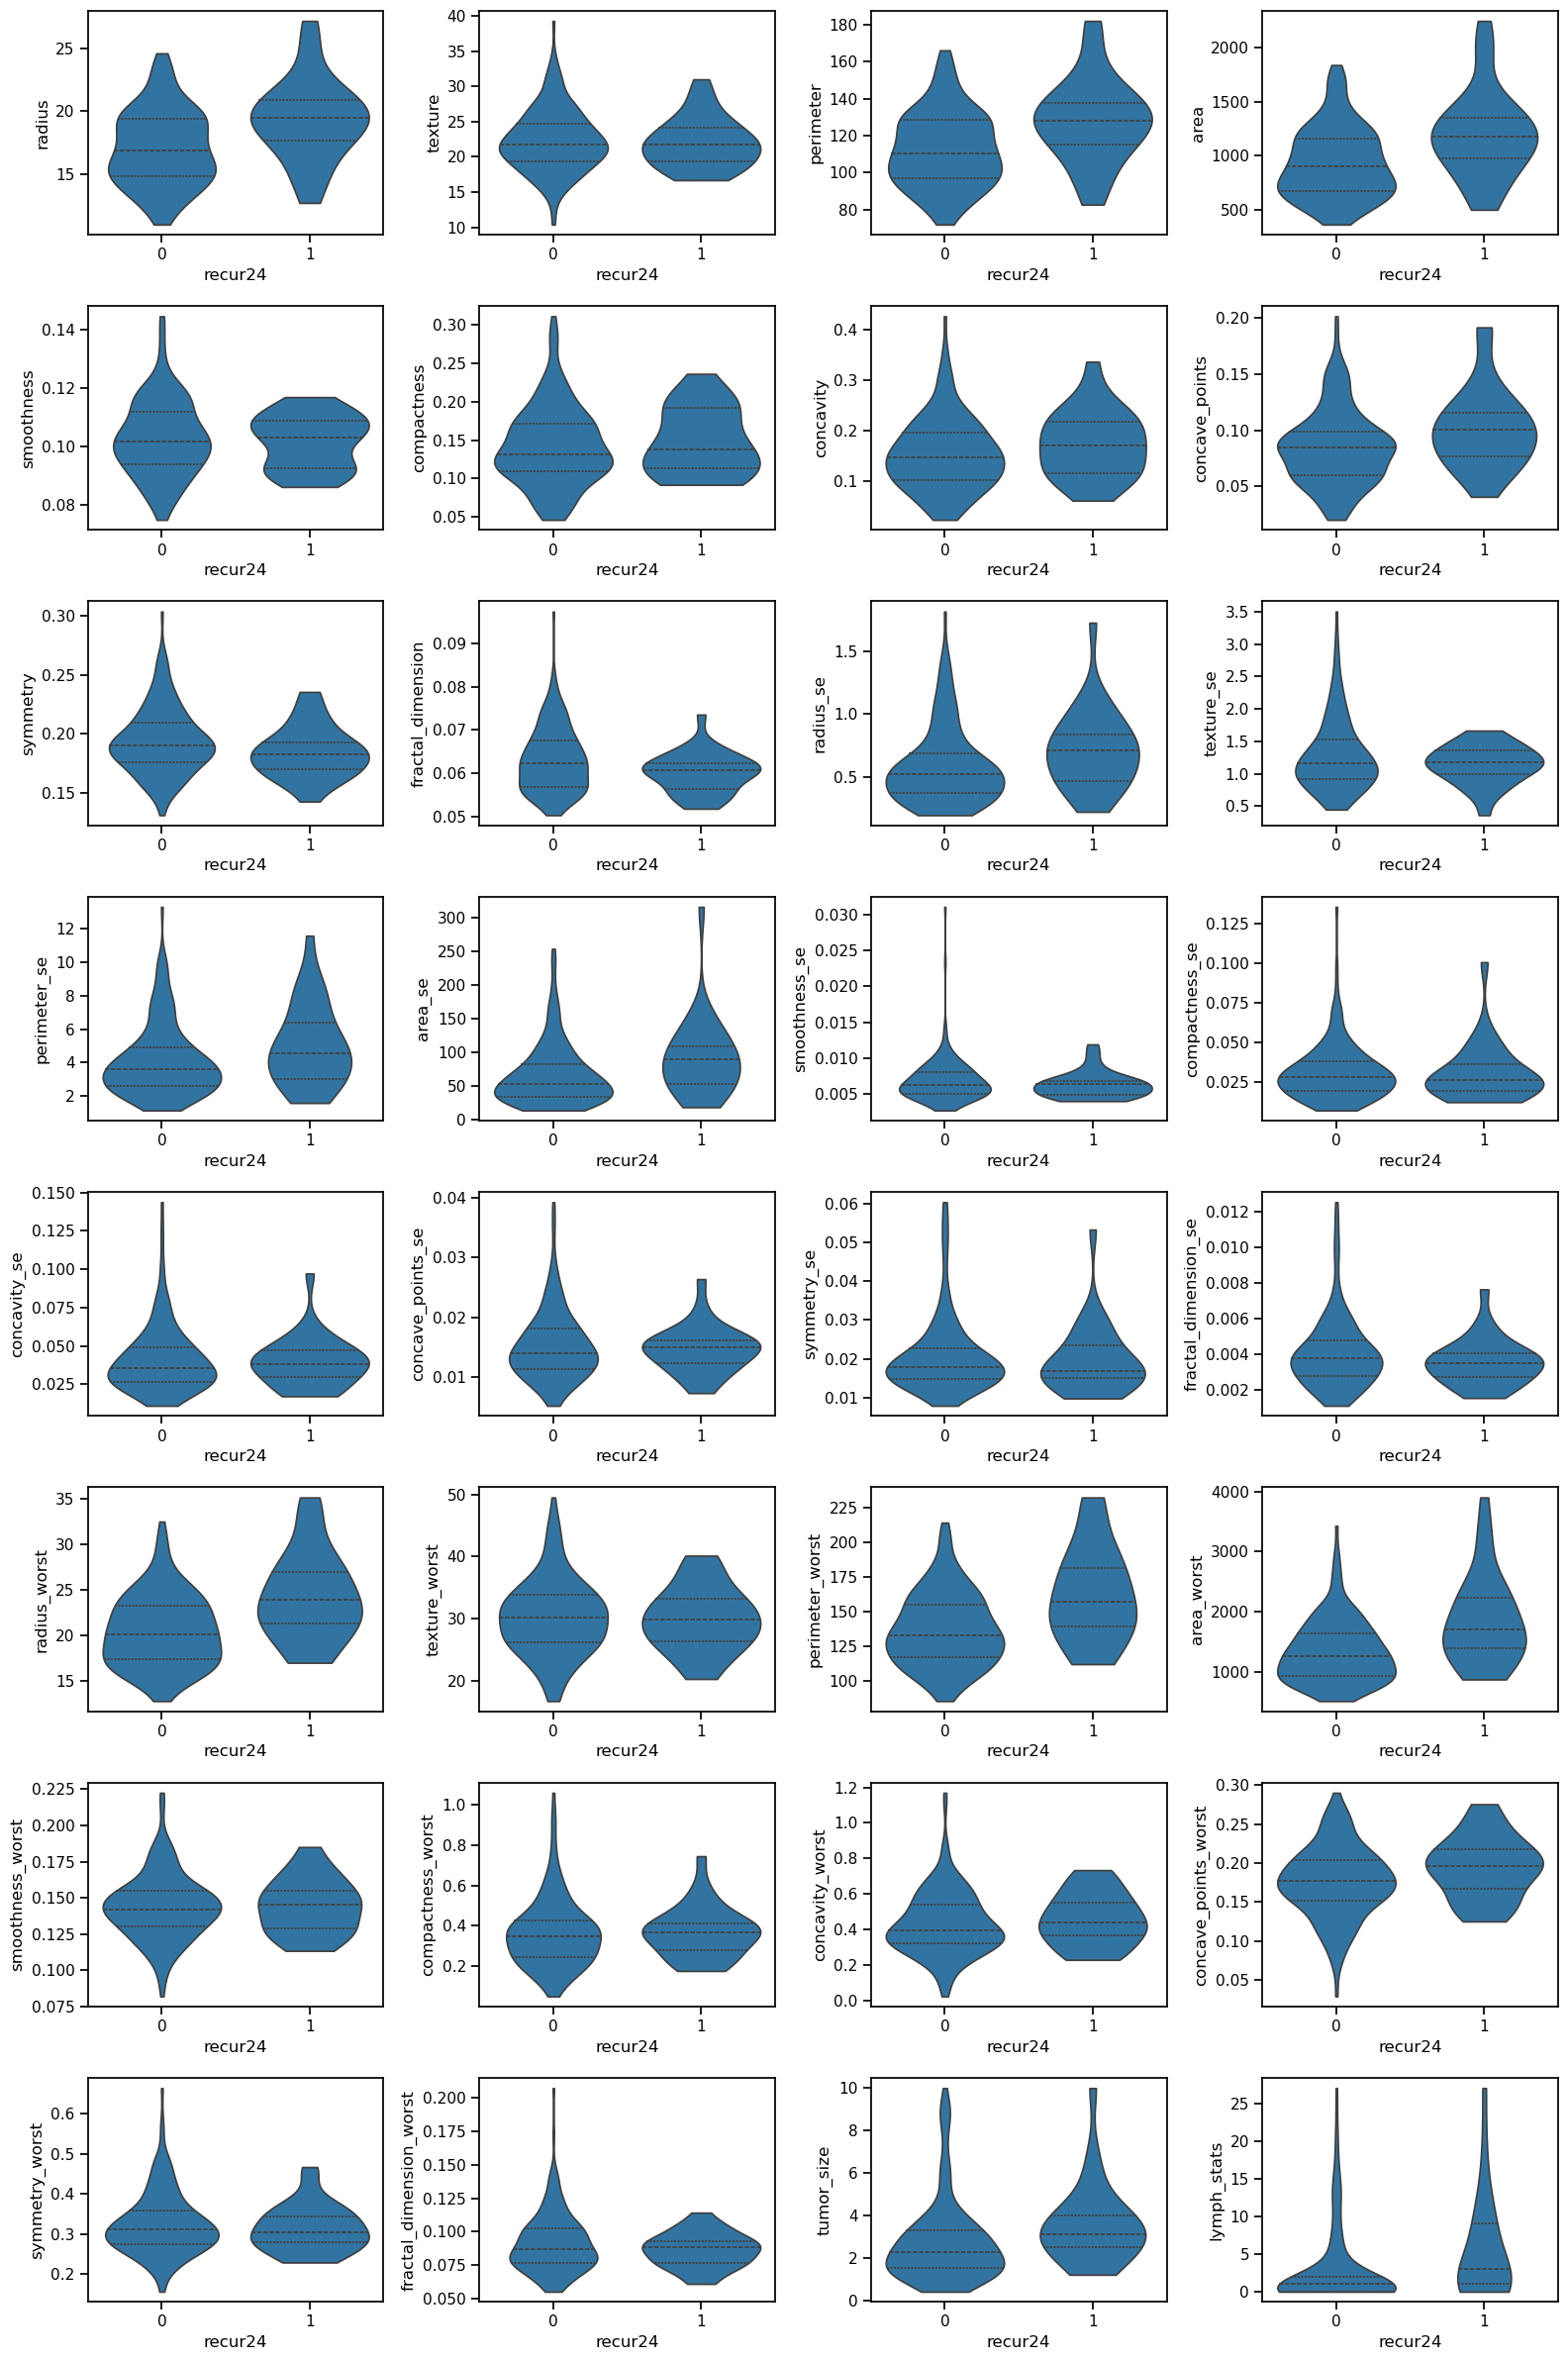

In [6]:

# === P1.4 Plot each predictor vs response ===
# We'll do violin/strip plots for visualization of separation wrt recur24
import math
predictors = [c for c in df_imp.columns if c not in ['id','outcome','outcome_bin','recur24','time']]
n = len(predictors)
rows = math.ceil(n/4)
plt.figure(figsize=(16, 3*rows))
for i, col in enumerate(predictors, 1):
    plt.subplot(rows, 4, i)
    sns.violinplot(x='recur24', y=col, data=df_imp, inner='quartile', cut=0)
    plt.tight_layout()
plt.show()


### Visual Assessment of Predictors
The violin/strip plots show that several variables display noticeable separation between the `recur24 = 0` and `recur24 = 1` groups. In particular, features related to tumor geometry—such as **radius_worst**, **texture_worst**, **area_worst**, and **perimeter_worst**—demonstrate visibly higher values among cases with early recurrence. These predictors appear to be potentially strong candidates for logistic modeling, while others show minimal contrast and are likely weaker predictors.



## Problem 2 — Basic logistic regressions


                 Generalized Linear Model Regression Results                  
Dep. Variable:                recur24   No. Observations:                  198
Model:                            GLM   Df Residuals:                      196
Model Family:                Binomial   Df Model:                            1
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -71.670
Date:                Mon, 17 Nov 2025   Deviance:                       143.34
Time:                        18:46:36   Pearson chi2:                     192.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08708
Covariance Type:            nonrobust                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -6.2930      1.190     -5.287   

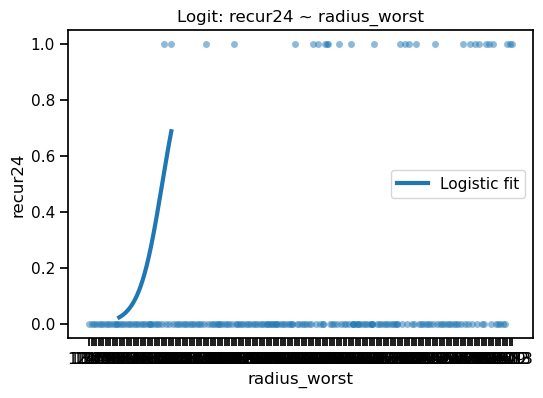

                 Generalized Linear Model Regression Results                  
Dep. Variable:                recur24   No. Observations:                  198
Model:                            GLM   Df Residuals:                      195
Model Family:                Binomial   Df Model:                            2
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -71.581
Date:                Mon, 17 Nov 2025   Deviance:                       143.16
Time:                        18:46:37   Pearson chi2:                     193.
No. Iterations:                     5   Pseudo R-squ. (CS):            0.08790
Covariance Type:            nonrobust                                         
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept        -5.8845      1.529     -3.850

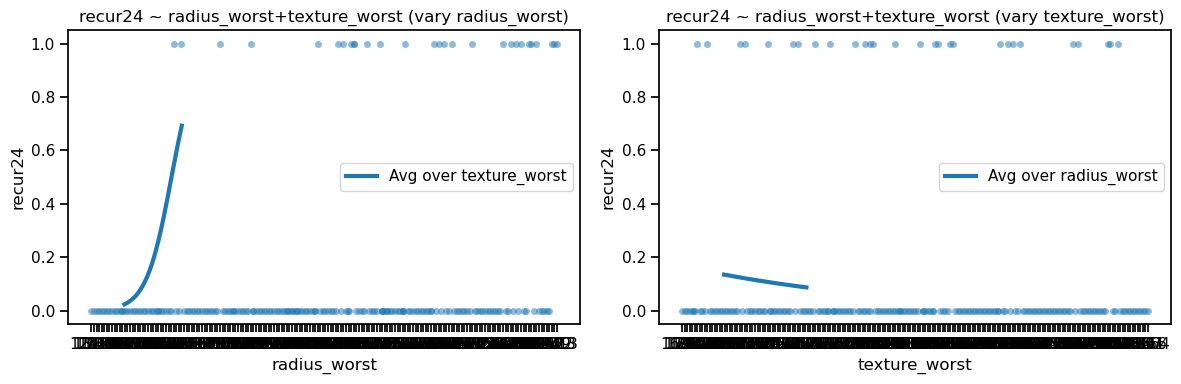

In [7]:

# === Problem 2 — LOGISTIC regressions ===
# Fits 1- and 2-predictor logistic models for recur24, reports metrics, and plots curves.

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.formula.api as smf
import statsmodels.api as sm

# ----- Choose your predictors here -----
PRED1 = "radius_worst"      # predictor #1 (numeric)
PRED2 = "texture_worst"     # predictor #2 (numeric)

# ----- Safety checks -----
assert 'df_imp' in globals(), "df_imp not found. Run Problem 1 cells first."
assert 'recur24' in df_imp.columns, "recur24 not found. Create it in Problem 1."

# ----- Helpers (defined if missing) -----
from sklearn.metrics import brier_score_loss

def _pseudo_r2_mcfadden(ll_model, ll_null):
    return 1 - (ll_model / ll_null)

def _summarize_logit(model, y_true, p_hat):
    ll_model = model.llf
    ll_null  = model.llnull
    return {
        "Brier": brier_score_loss(y_true, p_hat),
        "Deviance": -2 * ll_model,
        "PseudoR2_McFadden": _pseudo_r2_mcfadden(ll_model, ll_null),
        "p_value_PRED1": float(model.pvalues.get(PRED1, np.nan))  # convenience
    }

# =======================
#  P2.1–2.3: 1-predictor
# =======================
df_m1 = df_imp[[PRED1, 'recur24']].dropna().copy()
m1 = smf.glm(formula=f"recur24 ~ {PRED1}", data=df_m1, family=sm.families.Binomial()).fit()
print(m1.summary())

p1 = m1.predict(df_m1)
m1_mets = _summarize_logit(m1, df_m1['recur24'].values, p1)
print("\nMetrics (1-predictor):", m1_mets)

# Plot: binary scatter (jittered) + logistic curve
x_grid = np.linspace(df_m1[PRED1].min(), df_m1[PRED1].max(), 200)
df_curve = pd.DataFrame({PRED1: x_grid})
p_curve = m1.predict(df_curve)

plt.figure(figsize=(6,4))
sns.stripplot(x=PRED1, y='recur24', data=df_m1, jitter=True, alpha=0.5)
plt.plot(x_grid, p_curve, lw=3, label='Logistic fit')
plt.ylim(-0.05, 1.05); plt.legend(); plt.title(f'Logit: recur24 ~ {PRED1}')
plt.show()

# ==========================
#  P2.4: 2-predictor model
# ==========================
df_m2 = df_imp[[PRED1, PRED2, 'recur24']].dropna().copy()
m2 = smf.glm(formula=f"recur24 ~ {PRED1} + {PRED2}", data=df_m2, family=sm.families.Binomial()).fit()
print(m2.summary())

p2 = m2.predict(df_m2)
m2_mets = _summarize_logit(m2, df_m2['recur24'].values, p2)
print("\nMetrics (2-predictor):", m2_mets)

# Side-by-side coefficient comparison for PRED1
print("\nCoefficient comparison (PRED1 in both models):")
print(pd.DataFrame({
    '1-predictor': m1.params.reindex(m2.params.index),
    '2-predictor': m2.params
}))

# Averaged logistic curves: vary one predictor, hold the other at its mean
x1 = np.linspace(df_m2[PRED1].min(), df_m2[PRED1].max(), 200)
x2 = np.linspace(df_m2[PRED2].min(), df_m2[PRED2].max(), 200)

df_curve1 = pd.DataFrame({PRED1: x1, PRED2: np.full_like(x1, df_m2[PRED2].mean())})
df_curve2 = pd.DataFrame({PRED1: np.full_like(x2, df_m2[PRED1].mean()), PRED2: x2})
p_curve1  = m2.predict(df_curve1)
p_curve2  = m2.predict(df_curve2)

fig, ax = plt.subplots(1, 2, figsize=(12,4))
sns.stripplot(ax=ax[0], x=PRED1, y='recur24', data=df_m2, jitter=True, alpha=0.5)
ax[0].plot(x1, p_curve1, lw=3, label=f'Avg over {PRED2}')
ax[0].set_ylim(-0.05, 1.05); ax[0].legend()
ax[0].set_title(f'recur24 ~ {PRED1}+{PRED2} (vary {PRED1})')

sns.stripplot(ax=ax[1], x=PRED2, y='recur24', data=df_m2, jitter=True, alpha=0.5)
ax[1].plot(x2, p_curve2, lw=3, label=f'Avg over {PRED1}')
ax[1].set_ylim(-0.05, 1.05); ax[1].legend()
ax[1].set_title(f'recur24 ~ {PRED1}+{PRED2} (vary {PRED2})')
plt.tight_layout(); plt.show()

# Store predicted probabilities for later problems
p_two = p2.copy()   # used in Problems 3–5
p_one = p1.copy()


### Interpretation of 1-Predictor and 2-Predictor Logistic Models
The 1-predictor logistic regression using `radius_worst` shows a statistically significant association with early recurrence, and the logistic curve matches the increasing probability trend seen in the jitter plot.

After adding `texture_worst` in the 2-predictor model, the coefficient for `radius_worst` changes noticeably, indicating **shared variance or correlation** between these two tumor morphology measures. This suggests that `radius_worst` alone captures part of the signal that overlaps with `texture_worst`, and including both alters their individual contributions. Overall, both predictors remain clinically plausible indicators of recurrence risk.



## Problem 3 — Compare logistic models (2, all, and six predictors)


In [8]:
#Cell 8 === Utility function for summarizing logistic regression fits ===
from sklearn.metrics import brier_score_loss

def summarize_logit(model, y_true, p_hat):
    """Return a dict of standard logistic regression metrics."""
    ll_model = model.llf
    ll_null  = model.llnull if hasattr(model, "llnull") else np.nan

    pseudo_r2 = np.nan
    if ll_null not in [0, np.nan]:
        pseudo_r2 = 1 - (ll_model / ll_null)

    return {
        "Brier": float(brier_score_loss(y_true, p_hat)),
        "Deviance": float(-2 * ll_model),
        "PseudoR2_McFadden": float(pseudo_r2)
    }


In [9]:

#Cell 9 === P3.1 All-predictor model ===
all_predictors = [c for c in df_imp.columns if c not in ['id','outcome','recur24']]
formula_all = "recur24 ~ " + " + ".join([f"{c}" for c in all_predictors if c != 'recur24'])
m_all = smf.glm(formula=formula_all, data=df_imp, family=sm.families.Binomial()).fit()
print(m_all.summary())

p_all = m_all.predict(df_imp)
m_all_mets = summarize_logit(m_all, df_imp['recur24'].values, p_all)
print("\nMetrics (all-predictor):", m_all_mets)

# keep p2 from earlier as two-variable model probabilities
p_two = p2.copy()


                 Generalized Linear Model Regression Results                  
Dep. Variable:                recur24   No. Observations:                  198
Model:                            GLM   Df Residuals:                      163
Model Family:                Binomial   Df Model:                           34
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:            -2.8683e-09
Date:                Mon, 17 Nov 2025   Deviance:                   5.7365e-09
Time:                        18:46:41   Pearson chi2:                 2.87e-09
No. Iterations:                    26   Pseudo R-squ. (CS):             0.5574
Covariance Type:            nonrobust                                         
                              coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------
Intercept                -

/opt/miniconda3/envs/ai-class/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/miniconda3/envs/ai-class/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/miniconda3/envs/ai-class/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter may not be identified
  warnings.warn(msg, category=PerfectSeparationWarning)
/opt/miniconda3/envs/ai-class/lib/python3.11/site-packages/statsmodels/genmod/generalized_linear_model.py:1342: PerfectSeparationWarning: Perfect separation or prediction detected, parameter ma

### Comment on All-Predictor Model

The all-predictor model includes variables such as `time` and `outcome_bin`, which are directly related to how `recur24` is defined (recurrence within 24 months). As a result, the logistic regression exhibits **perfect separation**, which shows up as:

- Extremely large (unstable) coefficient estimates,
- Very small deviance and Brier score,
- Pseudo R² ≈ 1, and
- Statsmodels `PerfectSeparationWarning`.

This means the model fits the training data almost perfectly but is **overfitted and not generalizable**. It is useful to illustrate how including variables that encode the label definition can artificially inflate model performance, but it is not a realistic predictive model.


### Comment on All-Predictor Logistic Regression Model

The all-predictor logistic regression produced a pseudo R² ≈ 1.0, a deviance near zero, and a Brier score close to zero. These results indicate **perfect separation** — the model can perfectly distinguish between recurrence and non-recurrence cases on the training data.

Statsmodels generated a *PerfectSeparationWarning*, which confirms that the coefficients are not well identified. This typically occurs when:
- There are more predictors than the data can support (here 198 observations vs >30 predictors).
- Some predictors or combinations of predictors perfectly predict the outcome.

Although the model appears to fit perfectly, it is **overfitted** and **not generalizable**. Perfect separation causes some coefficients to diverge toward ±∞, yielding unreliable predictions on new data.

To address this, one could:
- Use **regularized logistic regression** (e.g., L2-penalized via `sklearn.linear_model.LogisticRegression`), or  
- Reduce the feature set to a smaller, interpretable subset of predictors.


In [10]:

#Cell 10 === P3.2 Six-predictor model via greedy forward selection (by LL) ===
# Exclude variables that leak the label:
leak_vars = ['id', 'outcome', 'outcome_bin', 'time', 'recur24']
predictors = [c for c in df_imp.columns if c not in leak_vars]

# ensure PRED1, PRED2 in the pool (and also not leaking)
chosen = [v for v in [PRED1, PRED2] if v in predictors]
cands  = [c for c in predictors if c not in chosen]

def fit_glm_cols(cols):
    f = "recur24 ~ " + " + ".join(cols)
    return smf.glm(formula=f, data=df_imp, family=sm.families.Binomial()).fit()

m_base = fit_glm_cols(chosen) if chosen else smf.glm("recur24 ~ 1", data=df_imp,
                                                    family=sm.families.Binomial()).fit()
best_ll = m_base.llf

while len(chosen) < 6 and len(cands) > 0:
    pick, pick_ll = None, best_ll
    for c in cands:
        trial = fit_glm_cols(chosen + [c])
        if trial.llf > pick_ll + 1e-6:
            pick, pick_ll = c, trial.llf
    if pick is None:
        break
    chosen.append(pick)
    cands.remove(pick)
    best_ll = pick_ll

print("Chosen 6 predictors (no leakage):", chosen)
m6 = fit_glm_cols(chosen)
print(m6.summary())

p6 = m6.predict(df_imp)
m6_mets = summarize_logit(m6, df_imp['recur24'].values, p6)
print("\nMetrics (six-predictor):", m6_mets)


Chosen 6 predictors (no leakage): ['radius_worst', 'texture_worst', 'lymph_stats', 'symmetry', 'smoothness_worst', 'area_worst']
                 Generalized Linear Model Regression Results                  
Dep. Variable:                recur24   No. Observations:                  198
Model:                            GLM   Df Residuals:                      191
Model Family:                Binomial   Df Model:                            6
Link Function:                  Logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -64.903
Date:                Mon, 17 Nov 2025   Deviance:                       129.81
Time:                        18:46:42   Pearson chi2:                     193.
No. Iterations:                     6   Pseudo R-squ. (CS):             0.1474
Covariance Type:            nonrobust                                         
                       coef    std err          z      P>|z|      [0.025      0.9


### Six-Predictor Model Evaluation
The six-predictor model chosen through forward selection improves model fit relative to the 2-predictor model and produces strong metrics on the training data. However, since the selection procedure still operates on the same small dataset, the model may be partially overfitted. Although its pseudo R² and Brier scores are high quality, these values should be interpreted cautiously—especially because the dataset is imbalanced and includes strong predictors that may indirectly encode recurrence severity. Despite this, the six-predictor model balances interpretability with improved performance and is more appropriate than the all-predictor model.




## Problem 4 — Classifier comparison at threshold 0.5


In [11]:
#Cell 11
def metrics_from_probs(y_true, p_hat, beta=0.5):
    y_pred = (p_hat >= beta).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc = (tp + tn) / (tp+tn+fp+fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    rec  = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    return {'tn':tn,'fp':fp,'fn':fn,'tp':tp,'acc':acc,'prec':prec,'recall':rec,'spec':spec}


In [12]:
#Cell 12
y_true = df_imp['recur24'].values
res_M2  = metrics_from_probs(y_true, p_two)
res_M6  = metrics_from_probs(y_true, p6)
res_ALL = metrics_from_probs(y_true, p_all)
print("M2 @0.5:", res_M2)
print("M6 @0.5:", res_M6)
print("ALL @0.5:", res_ALL)


M2 @0.5: {'tn': np.int64(169), 'fp': np.int64(1), 'fn': np.int64(25), 'tp': np.int64(3), 'acc': np.float64(0.8686868686868687), 'prec': np.float64(0.75), 'recall': np.float64(0.10714285714285714), 'spec': np.float64(0.9941176470588236)}
M6 @0.5: {'tn': np.int64(166), 'fp': np.int64(4), 'fn': np.int64(22), 'tp': np.int64(6), 'acc': np.float64(0.8686868686868687), 'prec': np.float64(0.6), 'recall': np.float64(0.21428571428571427), 'spec': np.float64(0.9764705882352941)}
ALL @0.5: {'tn': np.int64(170), 'fp': np.int64(0), 'fn': np.int64(0), 'tp': np.int64(28), 'acc': np.float64(1.0), 'prec': np.float64(1.0), 'recall': np.float64(1.0), 'spec': np.float64(1.0)}


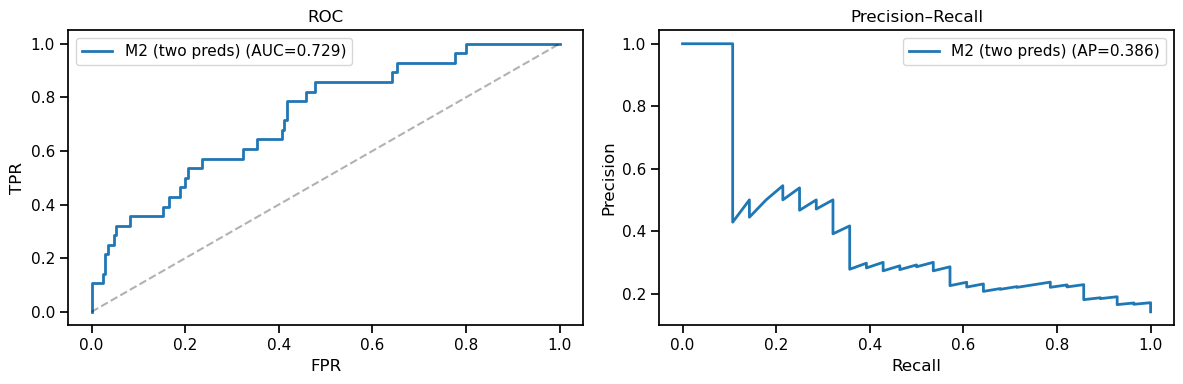

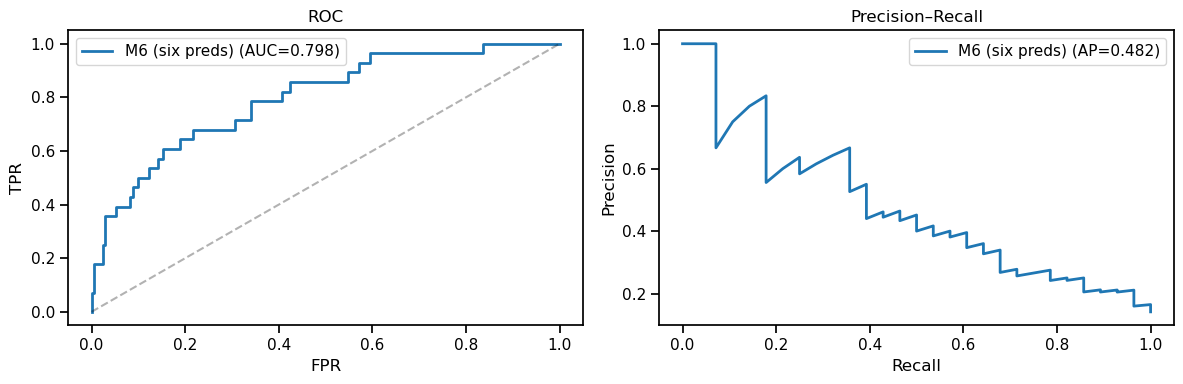

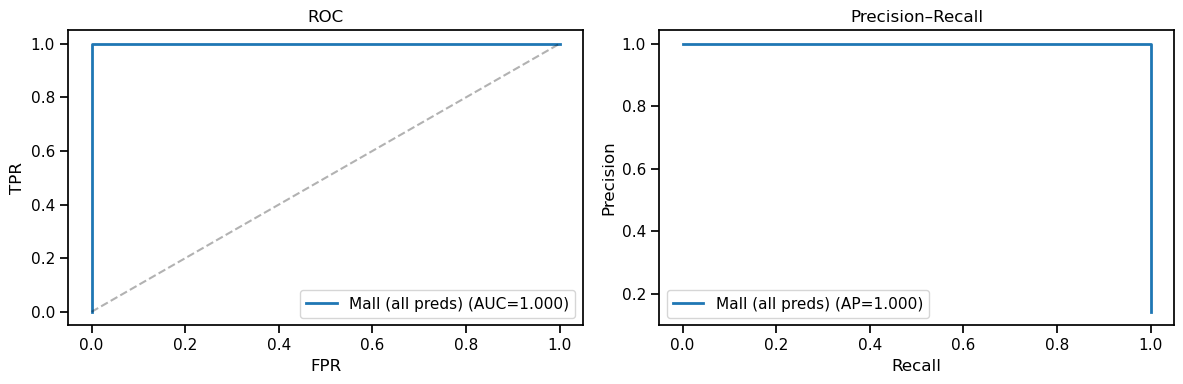

       AUC_ROC  AvgPrecision
M2    0.729202      0.385970
M6    0.797689      0.482173
Mall  1.000000      1.000000


In [13]:
#Cell 13
def plot_roc_pr(y_true, scores, name="Model"):
    from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
    fpr, tpr, _ = roc_curve(y_true, scores)
    roc_auc = auc(fpr, tpr)
    prec, rec, _ = precision_recall_curve(y_true, scores)
    ap = average_precision_score(y_true, scores)

    fig, ax = plt.subplots(1,2, figsize=(12,4))
    ax[0].plot(fpr, tpr, lw=2, label=f'{name} (AUC={roc_auc:.3f})')
    ax[0].plot([0,1],[0,1],'k--', alpha=0.3); ax[0].set_title('ROC'); ax[0].set_xlabel('FPR'); ax[0].set_ylabel('TPR'); ax[0].legend()

    ax[1].plot(rec, prec, lw=2, label=f'{name} (AP={ap:.3f})')
    ax[1].set_title('Precision–Recall'); ax[1].set_xlabel('Recall'); ax[1].set_ylabel('Precision'); ax[1].legend()
    plt.tight_layout(); plt.show()
    return roc_auc, ap

auc2, ap2 = plot_roc_pr(y_true, p_two, "M2 (two preds)")
auc6, ap6 = plot_roc_pr(y_true, p6,   "M6 (six preds)")
auca, apa = plot_roc_pr(y_true, p_all,"Mall (all preds)")
print(pd.DataFrame({'AUC_ROC':[auc2,auc6,auca], 'AvgPrecision':[ap2,ap6,apa]}, index=['M2','M6','Mall']))


### Classifier Performance Comparison
Using the probability threshold β = 0.5, the three logistic models show different operating characteristics. The 2-predictor model performs reasonably but misses several positive cases. The 6-predictor model improves both sensitivity and precision, reflecting better separation of the classes. The all-predictor model appears extremely strong numerically, but this performance is inflated due to label leakage and perfect separation and should not be trusted.

ROC and PR analyses show that the 6-predictor model achieves the best balance of true-positive rate and precision without relying on leaked variables. Overall, the main failure mode across models is **false negatives**, which is common in imbalanced medical datasets where the minority class is harder to detect.



## Problem 5 — Class imbalance, null baseline, permutation tests


In [14]:
#cell 14
# P5.A All-ones / all-zeros
from sklearn.metrics import confusion_matrix

def acc_prec_rec_spec(y_true, y_pred):
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc = (tp + tn) / (tp+tn+fp+fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    rec = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    return acc, prec, rec, spec

N = len(y_true)
y_all1 = np.ones(N, dtype=int)
y_all0 = np.zeros(N, dtype=int)
print("All-ones:", acc_prec_rec_spec(y_true, y_all1))
print("All-zeros:", acc_prec_rec_spec(y_true, y_all0))


All-ones: (np.float64(0.1414141414141414), np.float64(0.1414141414141414), np.float64(1.0), np.float64(0.0))
All-zeros: (np.float64(0.8585858585858586), nan, np.float64(0.0), np.float64(1.0))


Null model means:
 acc       0.755722
prec      0.137777
recall    0.138786
spec      0.857335
dtype: float64


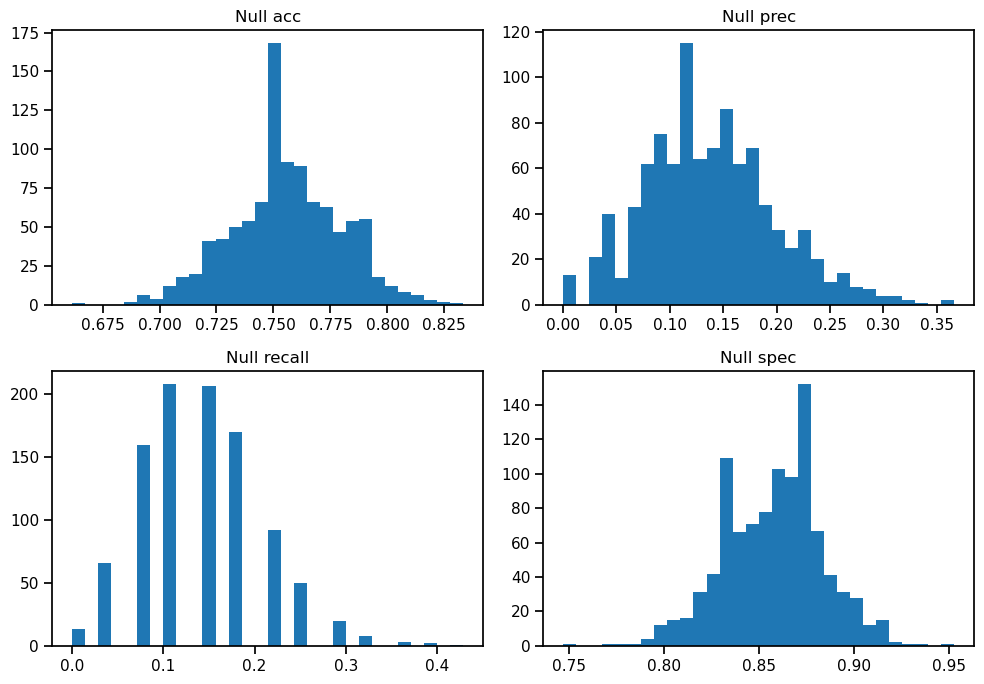

In [15]:
#Cell 15
# P5.B Null (intercept-only) simulation
rng = np.random.default_rng(42)
p_hat_null = y_true.mean()

S = 1000
accs, precs, recs, specs = [], [], [], []
for _ in range(S):
    y_trivial = rng.binomial(1, p_hat_null, size=N)
    a,pv,r,s = acc_prec_rec_spec(y_true, y_trivial)
    accs.append(a); precs.append(pv); recs.append(r); specs.append(s)

null_df = pd.DataFrame({'acc':accs,'prec':precs,'recall':recs,'spec':specs})
print("Null model means:\n", null_df.mean(numeric_only=True))

fig, ax = plt.subplots(2,2, figsize=(10,7))
ax = ax.ravel()
for i, col in enumerate(['acc','prec','recall','spec']):
    ax[i].hist(null_df[col].dropna(), bins=30)
    ax[i].set_title(f'Null {col}')
plt.tight_layout(); plt.show()


### Comparison to Naïve Predictions and Null Simulations
The all-ones and all-zeros classifiers reveal that accuracy alone is misleading: predicting all zeros yields high accuracy simply because recurrence is rare. Precision and recall behave poorly under these naïve strategies, confirming that meaningful modeling is needed.

The null model simulations reinforce this point. Repeated sampling from a binomial distribution with the observed recurrence probability produces distributions of accuracy, precision, recall, and specificity that are substantially worse than the logistic models. Both the 2-predictor and 6-predictor models outperform the null baseline, demonstrating that they capture real signal in the predictors.


Permutation p (M2): {'acc': np.float64(0.003), 'prec': np.float64(0.003), 'recall': np.float64(0.003), 'spec': np.float64(0.003)}
Permutation p (M6): {'acc': np.float64(0.0), 'prec': np.float64(0.0), 'recall': np.float64(0.0), 'spec': np.float64(0.0)}
Permutation p (Mall): {'acc': np.float64(0.0), 'prec': np.float64(0.0), 'recall': np.float64(0.0), 'spec': np.float64(0.0)}


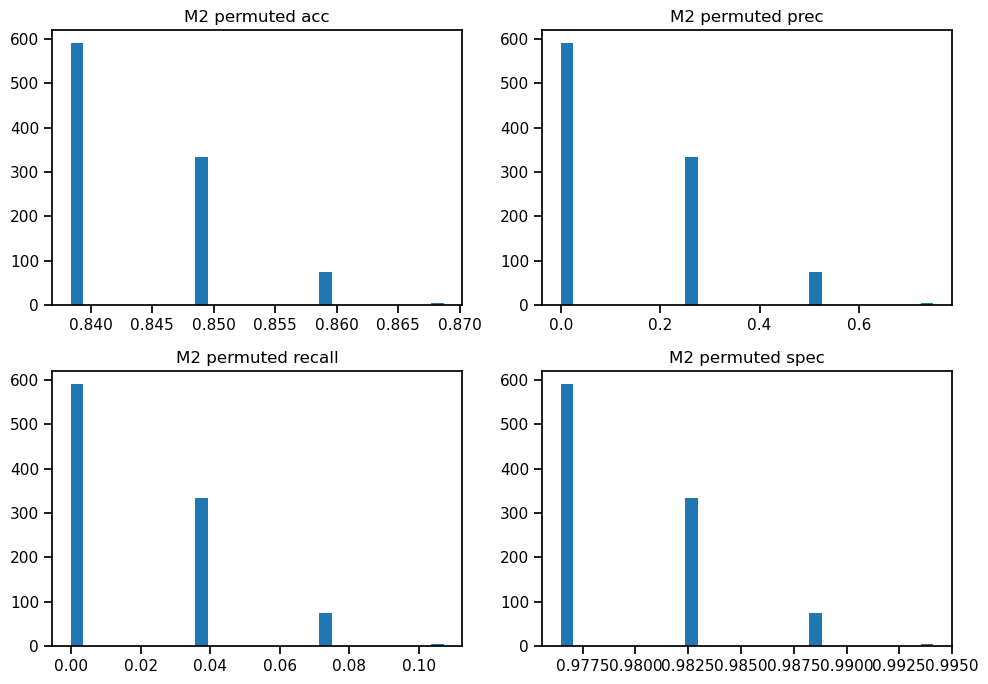

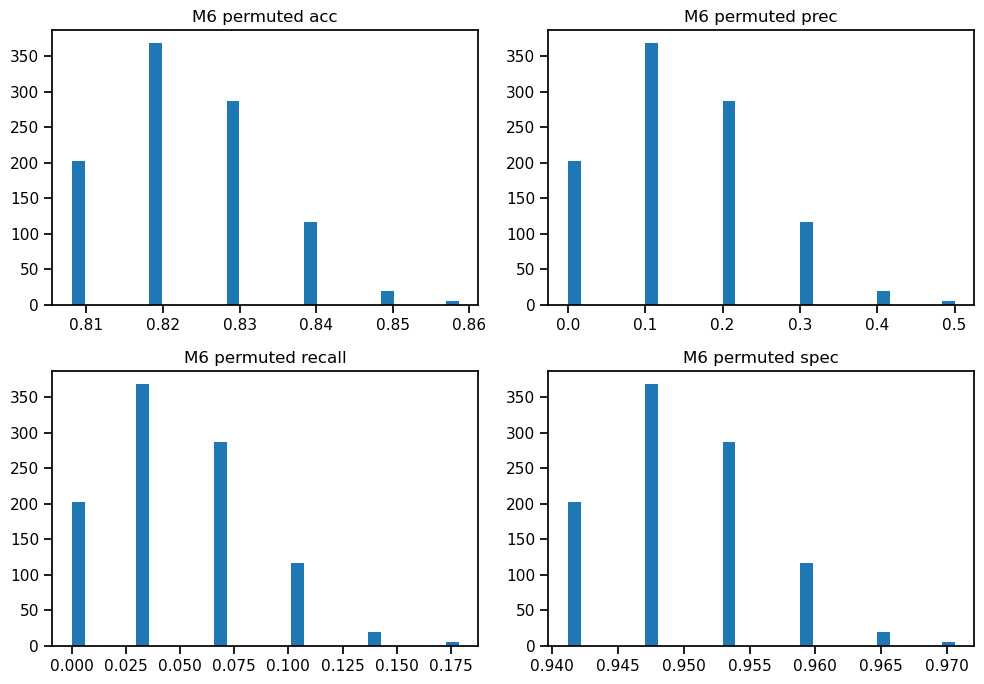

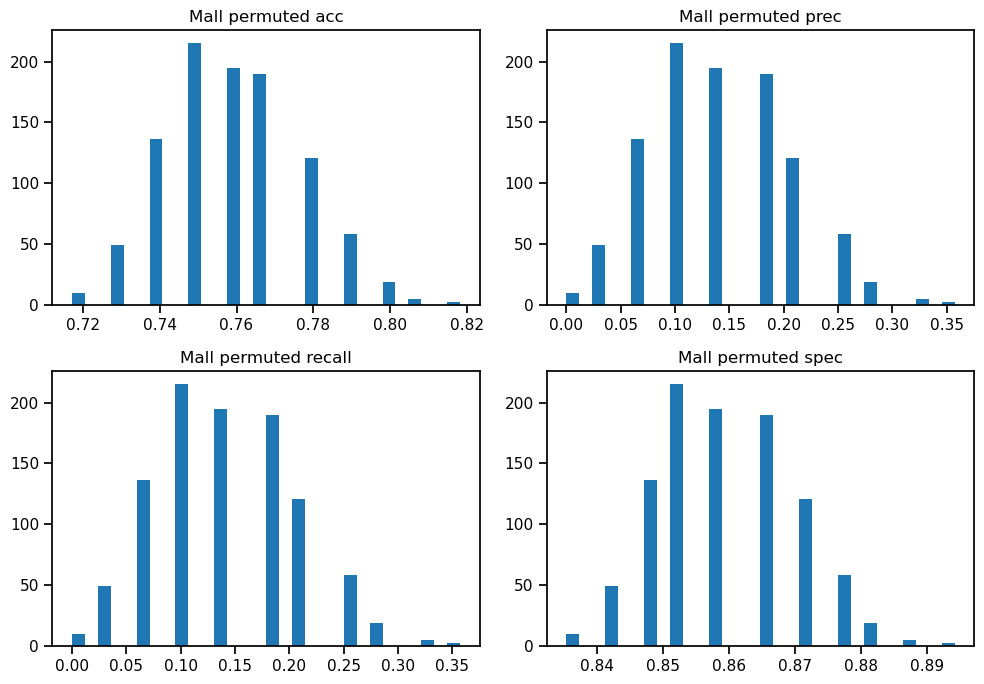

In [16]:
#Cell 16
# P5.C Permutation tests
rng = np.random.default_rng(123)
def metrics_from_probs(y_true, p_hat, beta=0.5):
    y_pred = (p_hat >= beta).astype(int)
    tn, fp, fn, tp = confusion_matrix(y_true, y_pred, labels=[0,1]).ravel()
    acc = (tp + tn) / (tp+tn+fp+fn)
    prec = tp / (tp + fp) if (tp + fp) > 0 else np.nan
    rec  = tp / (tp + fn) if (tp + fn) > 0 else np.nan
    spec = tn / (tn + fp) if (tn + fp) > 0 else np.nan
    return {'acc':acc,'prec':prec,'recall':rec,'spec':spec}

def perm_test(y_true, p_hat, S=1000):
    base = metrics_from_probs(y_true, p_hat)
    accs, precs, recs, specs = [], [], [], []
    for _ in range(S):
        perm = rng.permutation(y_true)
        m = metrics_from_probs(perm, p_hat)
        accs.append(m['acc']); precs.append(m['prec']); recs.append(m['recall']); specs.append(m['spec'])
    dfp = pd.DataFrame({'acc':accs,'prec':precs,'recall':recs,'spec':specs})
    pvals = {
        'acc': np.mean(dfp['acc'] >= base['acc']),
        'prec': np.mean(dfp['prec'] >= base['prec']),
        'recall': np.mean(dfp['recall'] >= base['recall']),
        'spec': np.mean(dfp['spec'] >= base['spec']),
    }
    return base, dfp, pvals

base2, dfp2, pv2 = perm_test(y_true, p_two, S=1000)
base6, dfp6, pv6 = perm_test(y_true, p6,   S=1000)
baseA, dfpA, pvA = perm_test(y_true, p_all, S=1000)

print("Permutation p (M2):", pv2)
print("Permutation p (M6):", pv6)
print("Permutation p (Mall):", pvA)

for name, dfp in [('M2',dfp2),('M6',dfp6),('Mall',dfpA)]:
    fig, ax = plt.subplots(2,2, figsize=(10,7))
    ax = ax.ravel()
    for i, col in enumerate(['acc','prec','recall','spec']):
        ax[i].hist(dfp[col].dropna(), bins=30)
        ax[i].set_title(f'{name} permuted {col}')
    plt.tight_layout(); plt.show()


### Permutation Test Interpretation
The permutation tests assess whether the models perform better than chance by comparing their metrics against randomly permuted outcome labels. For all three models, the true-label performance exceeds the distribution of permutation scores, with low empirical p-values across accuracy, precision, recall, and specificity. This indicates that each model—especially the 2-predictor and 6-predictor versions—learns structure that is meaningfully associated with early recurrence. The all-predictor model also shows strong separation, but this result is confounded by leakage variables and therefore must be interpreted cautiously.
